# Predicting Car Prices Using Supervised Learning


**Author:** Afraah Goshu


**Data Source:** Tugber Karan


## Overview

Car dealerships are always looking for new ways to attract and retain customers through traditional in-store experiences or increasingly through online platforms.. Cars.com is one such platform that connects  dealerships to potential buyers by hosting thousands of car listings across the United States. Optimizing car listings for best customer value is crucial to dealership success and customer satisfaction.


Product managers responsible for product pricing strategy need methods to identify which newly listed products need price adjustments based on features in order to enhance customer satisfaction and ultimately high conversion rates.   


This analysis aims to use supervised learning to extract insights from a dataset of used car listings scraped from Cars.com by Kaggle user Tugberk Karan. Since price is a continuous numeric variable, regression will be used. The observed price in this dataset will act as the ground-truth label in this supervised learning model. 
The following is a data dictionary for the scraped data. The ones highlighted will be used for analysis:



- **Brand** 
- Model  
- **Year**  
- **Mileage**  
- Engine  
- **Engine size (Float)**
- **Transmission**  
- Automatic transmission  
- **Fuel type** 
- Drive train  
- **Min mpg (Float)**  
- **Max mpg (Float)**  
- Damaged  
- First owner  
- Personal using  
- Turbo  
- Alloy Wheels  
- Adaptive cruise control  
- Navigation system  
- Power liftgate  
- Backup camera  
- Keyless start  
- Remote start  
- Sunroof / Moonroof  
- Automatic emergency braking  
- Stability control  
- Leather seats  
- Memory seat  
- Third row seating  
- Apple CarPlay / Android Auto  
- Bluetooth  
- USB port  
- Heated seats  
- Interior color  
- Exterior color  
- **Price (Float)**



Question that can be answered from this data:
- How can product managers responsible for pricing strategy optimize car listings for increased customer satisfaction?




**Source:** https://www.kaggle.com/datasets/tugberkkaran/used-car-listings-features-and-prices-carscom?select=train.csv

The following features will be used for the supervised regression model to predict Price:

- Brand (String)
- Year (Int)
- Mileage (Float)
- Engine (String)
- Engine size (Float)
- Transmission (String)
- Fuel type (String)
- Drive train (String)
- Min mpg (Float)
- Max mpg (Float)


# Data Acquisition

In [123]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import re
from scipy.sparse import lil_matrix
import scipy.spatial.distance
from sklearn import preprocessing
import sklearn
import pingouin as pg
import sklearn.metrics
from sklearn.linear_model import LinearRegression

path='train.csv'
df=pd.read_csv(path)
df.shape


(19109, 36)

# Data Preprocessing
Identifying columns needed for analysis

In [124]:
pd.set_option('display.max_columns', None)
df.drop_duplicates(subset=['model', 'year'], inplace=True)
df.head()

brand                      model    year  mileage  \
0       Mazda               CX-9 Touring  2022.0   6580.0   
1        Alfa  Romeo Stelvio 4DR SUV AWD  2018.0  62717.0   
2   Chevrolet  Silverado 1500 Limited LT  2022.0  15463.0   
3        Land  Rover Range Rover P400 SE  2022.0   1281.0   
4  Mitsubishi     Outlander Sport 2.0 SE  2021.0  36727.0   

                                      engine  engine_size       transmission  \
0                 2.5L I4 16V GDI DOHC Turbo          2.5  6-Speed Automatic   
1  Twin Turbo Premium Unleaded V-6 2.9 L/176          2.9          Automatic   
2                        5.3L V8 16V GDI OHV          5.3          Automatic   
3                 3.0L I6 24V GDI DOHC Turbo          3.0          Automatic   
4                      2.0L I4 16V MPFI DOHC          2.0      Automatic CVT   

   automatic_transmission fuel_type         drivetrain  min_mpg  max_mpg  \
0                     1.0  Gasoline   Four-wheel Drive      NaN      NaN   
1                     1.0  Gasoline   Four-wheel Drive      NaN      NaN   
2                     1.0  Gasoline   Four-wheel Drive      NaN      NaN   
3                     1.0  Gasoline   Four-wheel Drive      NaN      NaN   
4                     1.0  Gasoline  Front-wheel Drive      NaN      NaN   

   damaged  first_owner  personal_using  turbo  alloy_wheels  \
0      0.0          0.0             0.0    1.0           1.0   
1      0.0          0.0             1.0    1.0           0.0   
2      0.0          1.0             1.0    0.0           0.0   
3      0.0          1.0             1.0    1.0           0.0   
4      0.0          1.0             0.0    0.0           1.0   

   adaptive_cruise_control  navigation_system  power_liftgate  backup_camera  \
0                      0.0                0.0             1.0            1.0   
1                      1.0                1.0             1.0            1.0   
2                      0.0                0.0             0.0            0.0   
3                      1.0                1.0             1.0            1.0   
4                      0.0                0.0             0.0            1.0   

   keyless_start  remote_start  sunroof/moonroof  automatic_emergency_braking  \
0            0.0           0.0               1.0                          0.0   
1            1.0           1.0               0.0                          0.0   
2            0.0           1.0               0.0                          0.0   
3            0.0           1.0               1.0                          0.0   
4            1.0           0.0               0.0                          0.0   

   stability_control  leather_seats  memory_seat  third_row_seating  \
0                1.0            1.0          0.0                1.0   
1                1.0            0.0          1.0                0.0   
2                0.0            0.0          0.0                0.0   
3                1.0            1.0          1.0                0.0   
4                1.0            0.0          0.0                0.0   

   apple_car_play/android_auto  bluetooth  usb_port  heated_seats  \
0                          1.0        0.0       0.0           1.0   
1                          1.0        1.0       0.0           0.0   
2                          0.0        0.0       0.0           1.0   
3                          0.0        0.0       0.0           1.0   
4                          1.0        1.0       1.0           1.0   

  interior_color               exterior_color   price  
0          Black        Snowflake White Pearl   36789  
1          Black  Rosso Competizione Tri-Coat   39993  
2      Jet Black          Silver Ice Metallic   46986  
3          Ebony                   Fuji White  141999  
4          Black                        White   21595

Only considering newer (undamaged) vehicles for the regression analysis.


In [125]:
df=df[(df['damaged']==0)]


Selecting fewer variables for regression analysis (10 max) to reduce overfitting and multicolinearity. 
- brand
- model
- year
- mileage
- engine_size
- min_mpg
- max_mpg
- price
- fuel_type
- transmission

In [126]:
columns=['brand', 'model', 'year',  'mileage', 'engine_size', 'min_mpg', 'max_mpg', 'price', 'fuel_type', 'transmission']
df= df[columns]

## Data Exploration
Data before removing NA Values

In [127]:
df.describe()

year        mileage  engine_size      min_mpg      max_mpg
count  6174.000000    6174.000000  5732.000000  5065.000000  5065.000000
mean   2016.995951   48163.284742     3.294260    20.549852    27.452517
std       6.724267   41424.382590     9.514055     6.292182     6.826223
min    1962.000000       0.000000     0.000000     0.000000     0.000000
25%    2015.000000   16176.500000     2.000000    17.000000    23.000000
50%    2019.000000   37589.000000     3.000000    20.000000    27.000000
75%    2021.000000   70981.250000     3.600000    23.000000    31.000000
max    2024.000000  361662.000000   390.000000    89.000000   100.000000

Total NA Values in the dataset

In [128]:
df.isna().sum()

brand              0
model              0
year               0
mileage            0
engine_size      442
min_mpg         1109
max_mpg         1109
price              0
fuel_type          0
transmission      52
dtype: int64

# Data Cleaning 
Missing values, Correcting Datatypes, Handling Dupes
- convert price from string to float
- clean up transmission categories
- filtering for Years 2015 and above
- recategorizing brand to brand type (luxury, premium, standard/ economy)


In [129]:
df.dropna(inplace=True)
df=df.drop_duplicates()

Data After NA Removal

In [130]:
df.describe()

year        mileage  engine_size      min_mpg      max_mpg
count  4714.000000    4714.000000  4714.000000  4714.000000  4714.000000
mean   2017.056003   50196.748621     3.054922    20.591854    27.509334
std       5.793446   40786.390989     5.761446     6.145397     6.655541
min    1962.000000       0.000000     0.000000     0.000000     0.000000
25%    2015.000000   18950.500000     2.000000    17.000000    23.000000
50%    2019.000000   40264.000000     2.900000    20.000000    27.000000
75%    2021.000000   73336.750000     3.600000    23.000000    31.000000
max    2024.000000  361662.000000   390.000000    80.000000    94.000000

In [131]:
df.shape

(4714, 10)


- Filtering for years 2015-2023


In [132]:
df=df[(df['year']>=2015) & (df['year']<2024)]

In [133]:
df.shape

(3663, 10)

In [134]:
df['brand'].value_counts()

brand
Mercedes-Benz    234
Audi             234
Toyota           221
BMW              216
Lexus            189
Honda            186
Volkswagen       178
Nissan           173
Hyundai          170
Chevrolet        169
Ford             162
Porsche          158
Volvo            154
Cadillac         145
Kia              143
Jeep             141
Land             127
Mazda            126
Mitsubishi       117
Maserati         116
MINI              97
Jaguar            92
FIAT              61
Alfa              54
Name: count, dtype: int64

In [135]:
df['transmission'].value_counts()

transmission
8-Speed Automatic                   1140
6-Speed Automatic                    504
Automatic                            485
Automatic CVT                        389
9-Speed Automatic                    271
                                    ... 
10-Speed Shiftable Automatic           1
6-SPEED A/T                            1
6-Speed A/T                            1
8-Speed Automatic Sport                1
7G-TRONIC PLUS 7-Speed Automatic       1
Name: count, Length: 72, dtype: int64

In [136]:
def convert_numeric(cell):
    try: 
        cell=float(cell)
    except ValueError:
        cell=float('Nan')
    return cell
df['price']=df['price'].apply(convert_numeric)
df.describe()

year        mileage  engine_size      min_mpg      max_mpg  \
count  3663.000000    3663.000000  3663.000000  3663.000000  3663.000000   
mean   2019.429156   38850.141960     2.887933    20.712531    27.640732   
std       2.293662   31006.371025     1.150521     6.076211     6.558629   
min    2015.000000       5.000000     0.000000     0.000000     0.000000   
25%    2018.000000   15102.500000     2.000000    17.000000    24.000000   
50%    2020.000000   31344.000000     2.500000    20.000000    27.000000   
75%    2021.000000   56699.500000     3.500000    23.000000    31.000000   
max    2023.000000  204288.000000     6.700000    80.000000    94.000000   

               price  
count    3663.000000  
mean    42362.277641  
std     31752.684047  
min      7000.000000  
25%     25250.000000  
50%     34995.000000  
75%     48998.000000  
max    795000.000000

In [137]:
def group_transmission(transmission):
    if not isinstance(transmission, str):
        return 'Other/Unknown'
    
    transmission = transmission.lower()

    if 'manual' in transmission or re.search(r'\b(m/t|m\/t)\b', transmission):
        return 'Manual'
    elif 'cvt' in transmission or 'xtronic' in transmission or 'ivt' in transmission:
        return 'CVT'
    elif 'dual-clutch' in transmission or 'dct' in transmission or 'doppelkupplung' in transmission or 's tronic' in transmission or 'dsr' in transmission:
        return 'Dual-Clutch'
    elif 'shiftable' in transmission or 'tiptronic' in transmission or 'steptronic' in transmission or 'select-shift' in transmission or 'shiftronic' in transmission:
        return 'Shiftable Automatic'
    elif 'auto' in transmission or 'a/t' in transmission or 'automatic' in transmission:
        return 'Automatic'
    else:
        return 'Other/Unknown'
    
df['transmission'] = df['transmission'].apply(group_transmission)

In [138]:
df['transmission'].value_counts()

transmission
Automatic              3042
CVT                     402
Manual                  151
Shiftable Automatic      41
Other/Unknown            25
Dual-Clutch               2
Name: count, dtype: int64

In [139]:
def map_brand_type(brand):
    if brand in ['Audi', 'BMW', 'Cadillac', 'Jaguar', 'Land', 'Lexus', 'Maserati', 'Mercedes-Benz', 'Porsche', 'Volvo']:
        return 'Luxury'
    elif brand in ['Volkswagen', 'MINI', 'Mazda']:
        return 'Premium'
    elif brand in ['Chevrolet', 'Ford', 'Honda', 'Hyundai', 'Jeep', 'Kia', 'Mitsubishi', 'Nissan', 'Toyota', 'FIAT', 'Alfa']:
        return 'Standard/ Economy'
    else:
        return 'Other'

df['brand_type'] = df['brand'].apply(map_brand_type)

# Summary Visuals

There seems to be a 1-1 correlation between min and max mpg so substituting for the mpg range will be more appropriate for this analsis

In [140]:
df['mpg_range'] = df['max_mpg'] - df['min_mpg']
df.drop(['max_mpg', 'min_mpg'], axis=1, inplace=True)
df.describe()

year        mileage  engine_size          price    mpg_range
count  3663.000000    3663.000000  3663.000000    3663.000000  3663.000000
mean   2019.429156   38850.141960     2.887933   42362.277641     6.928201
std       2.293662   31006.371025     1.150521   31752.684047     2.521243
min    2015.000000       5.000000     0.000000    7000.000000     0.000000
25%    2018.000000   15102.500000     2.000000   25250.000000     5.000000
50%    2020.000000   31344.000000     2.500000   34995.000000     7.000000
75%    2021.000000   56699.500000     3.500000   48998.000000     8.000000
max    2023.000000  204288.000000     6.700000  795000.000000    48.000000

## Observations with outliers

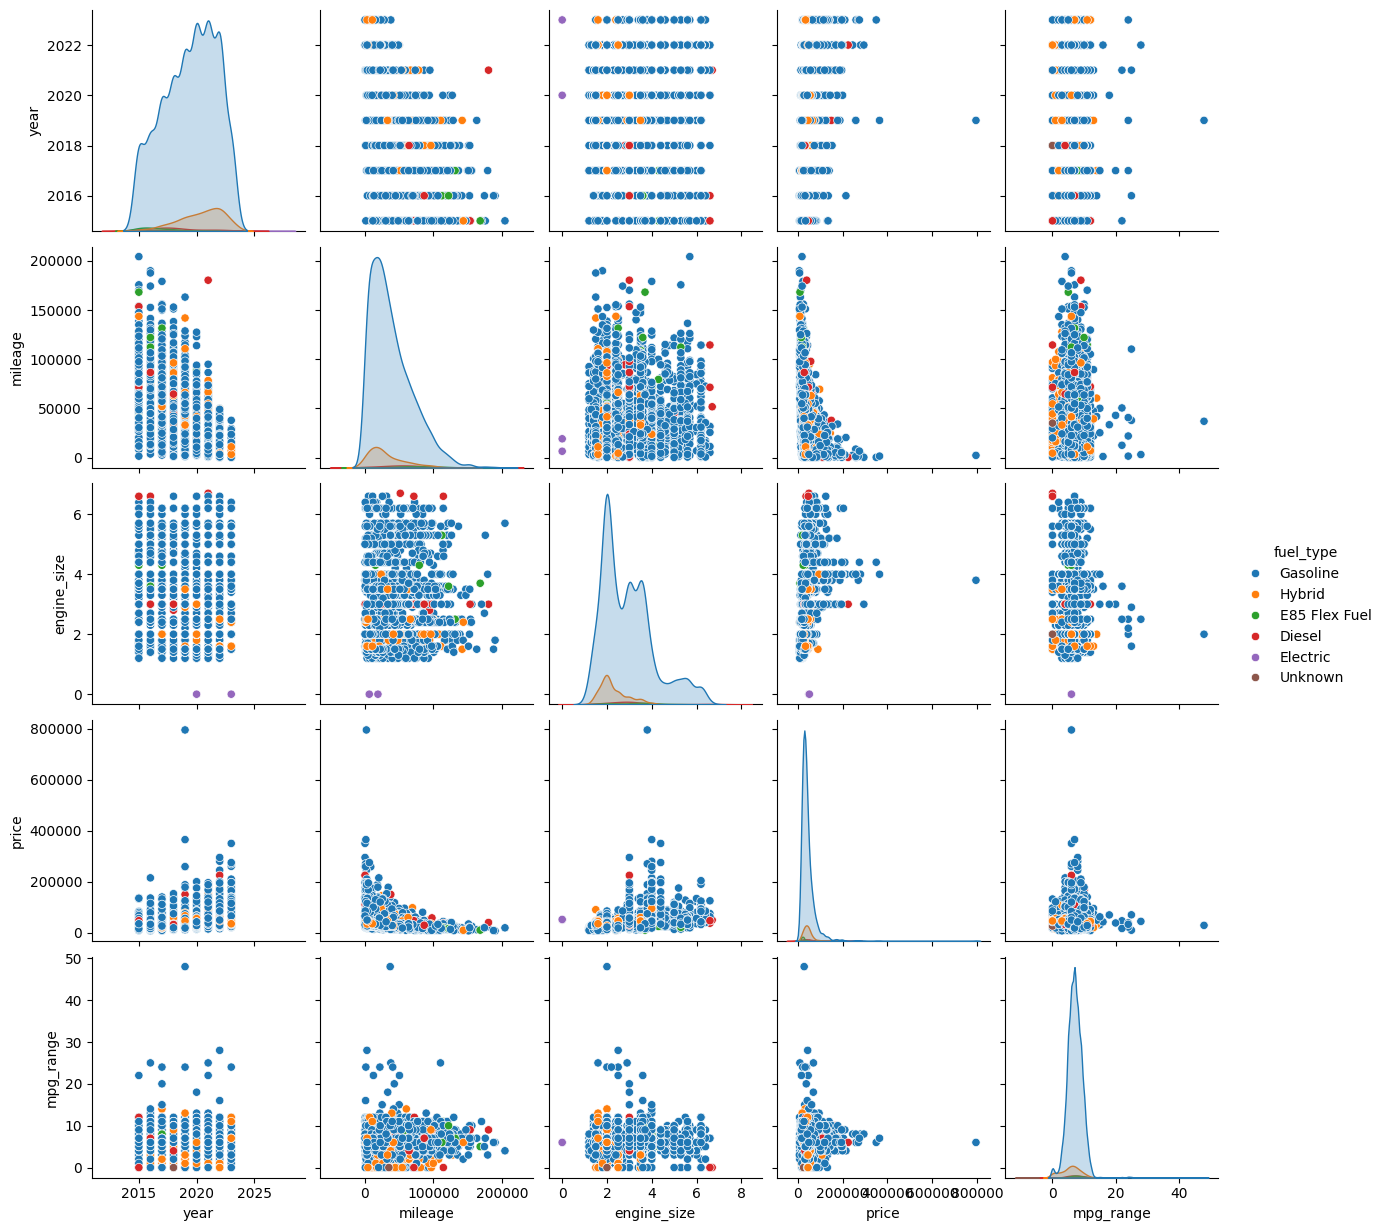

In [141]:
sns.pairplot(df, hue='fuel_type')

plt.show()

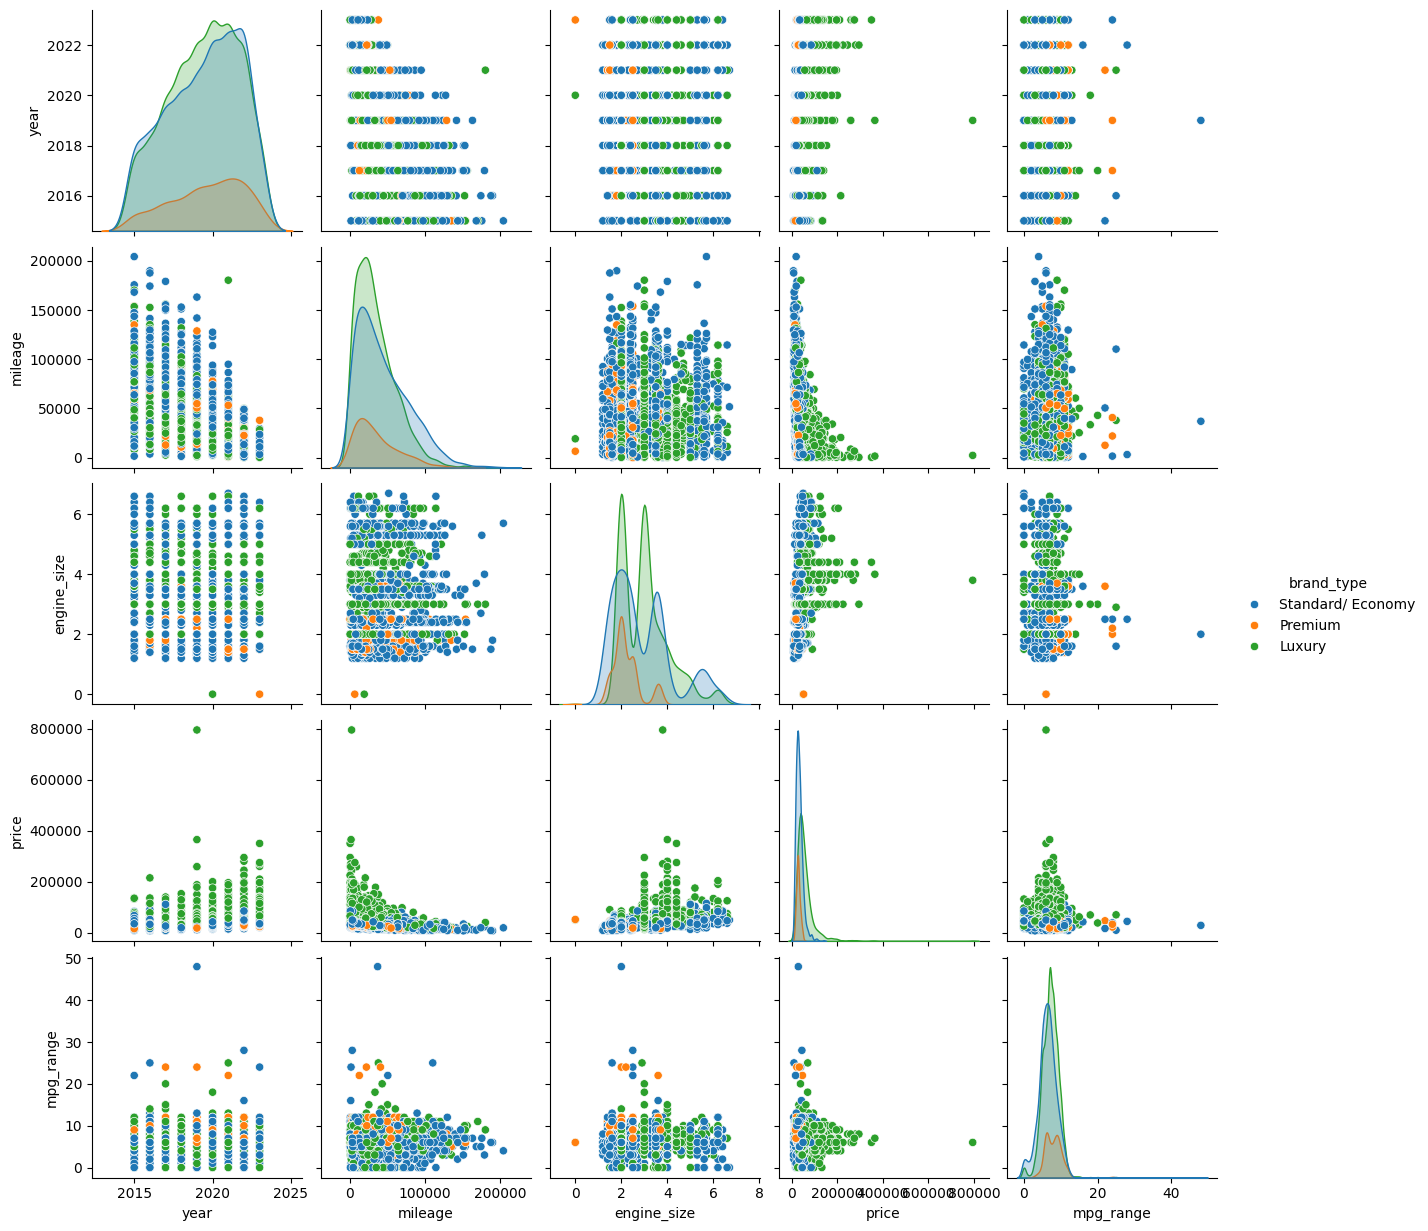

In [142]:
sns.pairplot(df, hue='brand_type')

plt.show()

## Observations without Outliers

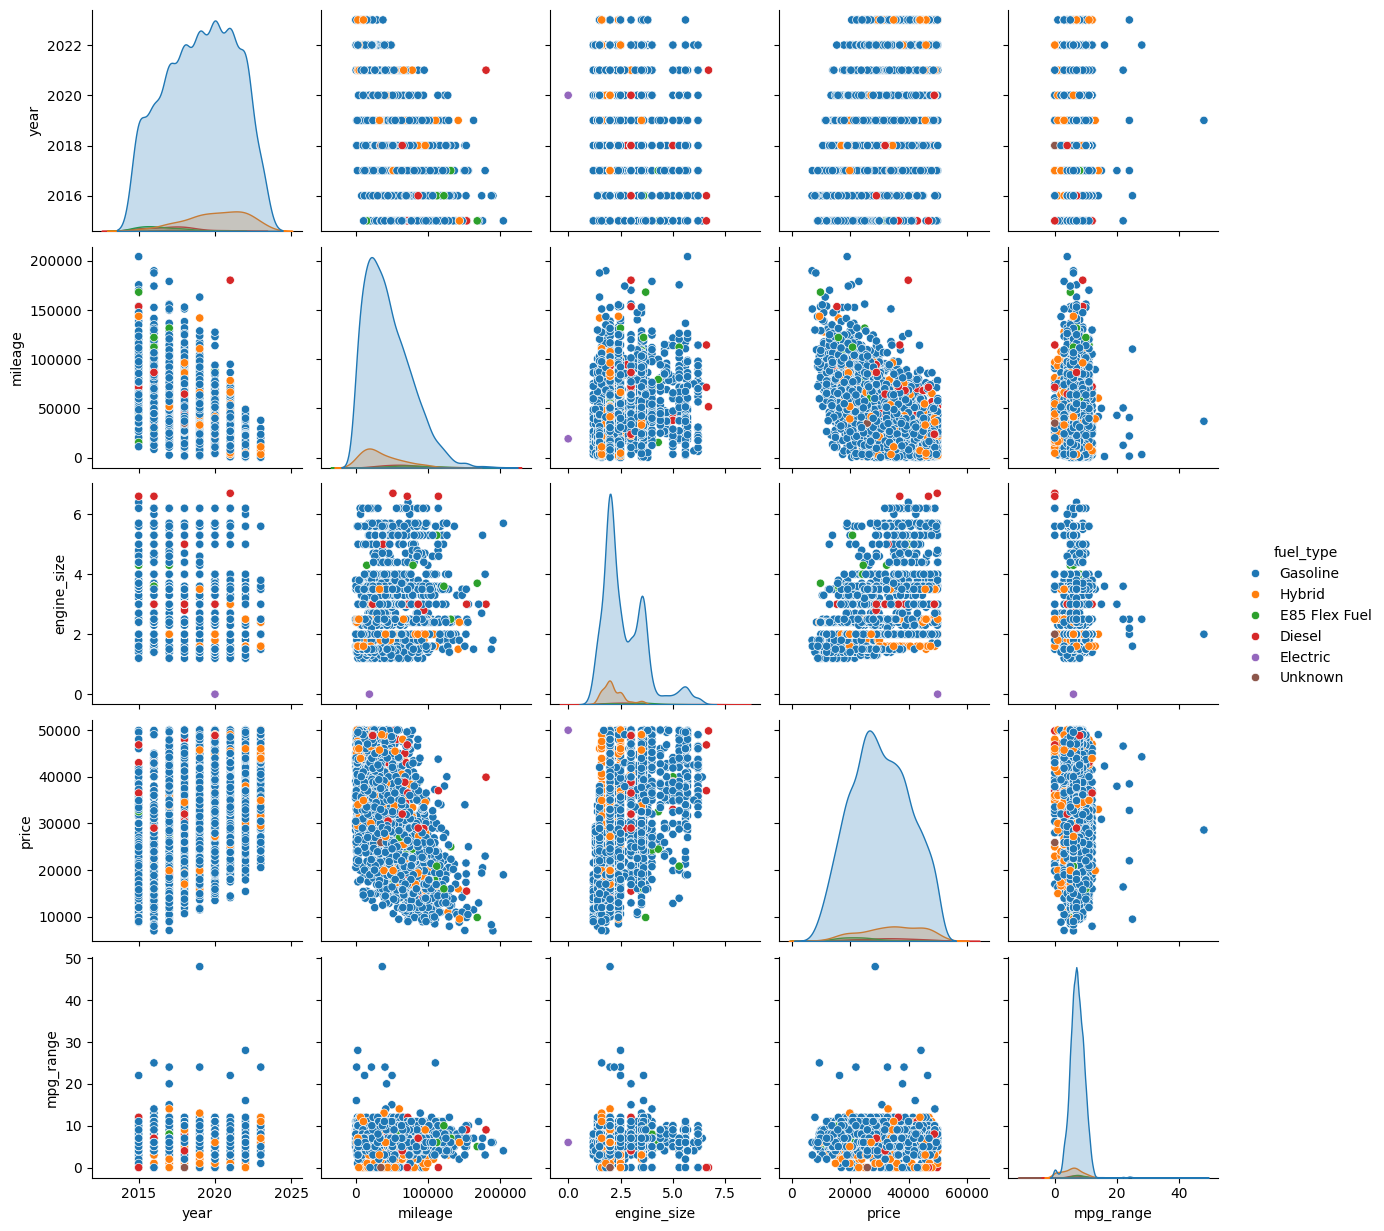

In [143]:
sns.pairplot(df[df['price']<50000], hue='fuel_type')
plt.show()

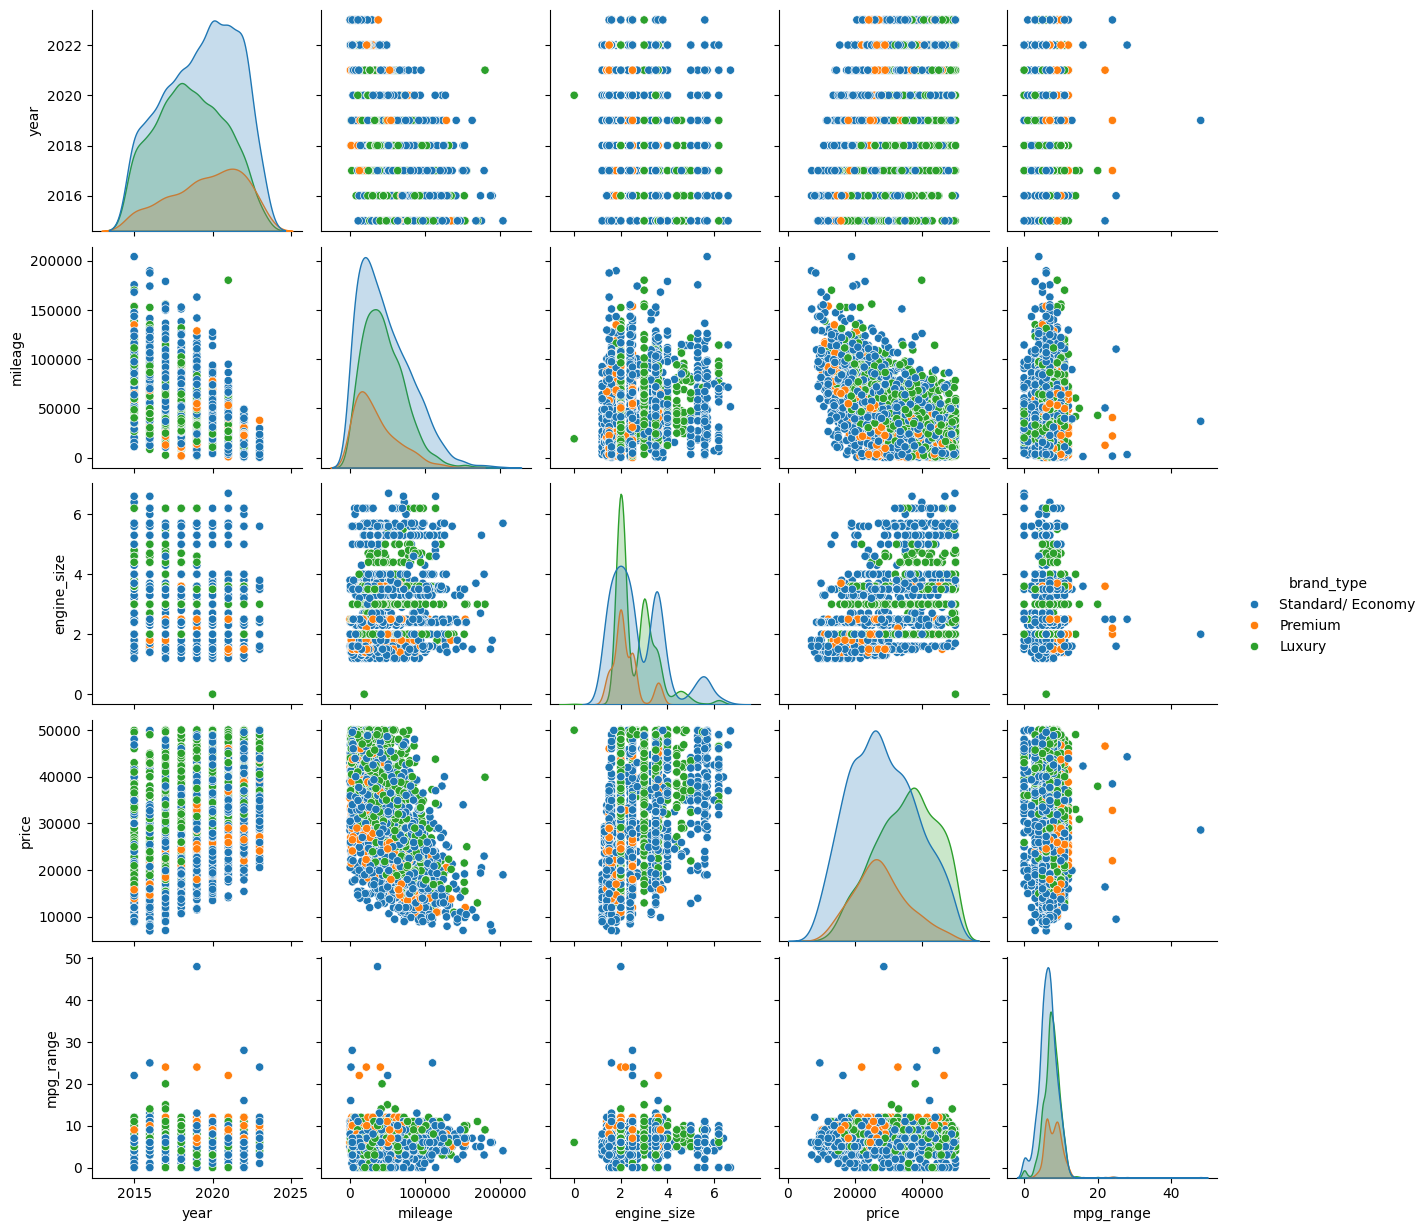

In [144]:
sns.pairplot(df[df['price']<50000], hue='brand_type')
plt.show()

Creating Dummy Variables for categorical variables such as: brand,fueltype, and transmission 

In [145]:

cdf = pd.get_dummies(df, columns=[ 'brand_type', 'fuel_type', 'transmission'], prefix='', prefix_sep='', dtype=float)
cdf=cdf.set_index('model')
cdf

brand    year  mileage  engine_size     price  \
model                                                                       
Pilot Special Edition       Honda  2021.0  51299.0          3.5   35999.0   
Outlander Sport SE     Mitsubishi  2021.0  31976.0          2.0   19499.0   
Hardtop Cooper               MINI  2016.0  43418.0          1.5   16500.0   
Niro LXS                      Kia  2020.0  20247.0          1.6   22995.0   
F-PACE SVR                 Jaguar  2023.0   4385.0          5.0   89977.0   
...                           ...     ...      ...          ...       ...   
Camry                      Toyota  2020.0  39840.0          2.5   27900.0   
Mazda6 Sport                Mazda  2019.0  54700.0          2.5   17999.0   
Titan PRO-4X               Nissan  2022.0   3196.0          5.6   49500.0   
ALPINA XB7 Base               BMW  2021.0  22386.0          4.4  119999.0   
Camaro 2SS              Chevrolet  2020.0  30921.0          6.2   42500.0   

                       mpg_range  Luxury  Premium  Standard/ Economy  Diesel  \
model                                                                          
Pilot Special Edition        7.0     0.0      0.0                1.0     0.0   
Outlander Sport SE           7.0     0.0      0.0                1.0     0.0   
Hardtop Cooper              10.0     0.0      1.0                0.0     0.0   
Niro LXS                    11.0     0.0      0.0                1.0     0.0   
F-PACE SVR                   5.0     1.0      0.0                0.0     0.0   
...                          ...     ...      ...                ...     ...   
Camry                       11.0     0.0      0.0                1.0     0.0   
Mazda6 Sport                 7.0     0.0      1.0                0.0     0.0   
Titan PRO-4X                 6.0     0.0      0.0                1.0     0.0   
ALPINA XB7 Base              6.0     1.0      0.0                0.0     0.0   
Camaro 2SS                   8.0     0.0      0.0                1.0     0.0   

                       E85 Flex Fuel  Electric  Gasoline  Hybrid  Unknown  \
model                                                                       
Pilot Special Edition            0.0       0.0       1.0     0.0      0.0   
Outlander Sport SE               0.0       0.0       1.0     0.0      0.0   
Hardtop Cooper                   0.0       0.0       1.0     0.0      0.0   
Niro LXS                         0.0       0.0       0.0     1.0      0.0   
F-PACE SVR                       0.0       0.0       1.0     0.0      0.0   
...                              ...       ...       ...     ...      ...   
Camry                            0.0       0.0       1.0     0.0      0.0   
Mazda6 Sport                     0.0       0.0       1.0     0.0      0.0   
Titan PRO-4X                     0.0       0.0       1.0     0.0      0.0   
ALPINA XB7 Base                  0.0       0.0       1.0     0.0      0.0   
Camaro 2SS                       0.0       0.0       1.0     0.0      0.0   

                       Automatic  CVT  Dual-Clutch  Manual  Other/Unknown  \
model                                                                       
Pilot Special Edition        1.0  0.0          0.0     0.0            0.0   
Outlander Sport SE           0.0  1.0          0.0     0.0            0.0   
Hardtop Cooper               1.0  0.0          0.0     0.0            0.0   
Niro LXS                     1.0  0.0          0.0     0.0            0.0   
F-PACE SVR                   1.0  0.0          0.0     0.0            0.0   
...                          ...  ...          ...     ...            ...   
Camry                        1.0  0.0          0.0     0.0            0.0   
Mazda6 Sport                 1.0  0.0          0.0     0.0            0.0   
Titan PRO-4X                 1.0  0.0          0.0     0.0            0.0   
ALPINA XB7 Base              1.0  0.0          0.0     0.0            0.0   
Camaro 2SS                   1.0  0.0          0.0     0.0 

In [146]:
cdf.isna().sum()
cdf.dropna(inplace=True)    

# Regression Analysis
Removing dummy references to prevent multicolinearity during analysis:
- transmission: other/unknown and shiftable automatic??
- fueltype : unknown
- brand type: standard/ economy

In [147]:
columns=[x for x in cdf.columns if x not in ['price', 'Other/Unknown', 'Unknown', 'brand', 'Standard/ Economy']]

cdf[columns]

year  mileage  engine_size  mpg_range  Luxury  \
model                                                                    
Pilot Special Edition  2021.0  51299.0          3.5        7.0     0.0   
Outlander Sport SE     2021.0  31976.0          2.0        7.0     0.0   
Hardtop Cooper         2016.0  43418.0          1.5       10.0     0.0   
Niro LXS               2020.0  20247.0          1.6       11.0     0.0   
F-PACE SVR             2023.0   4385.0          5.0        5.0     1.0   
...                       ...      ...          ...        ...     ...   
Camry                  2020.0  39840.0          2.5       11.0     0.0   
Mazda6 Sport           2019.0  54700.0          2.5        7.0     0.0   
Titan PRO-4X           2022.0   3196.0          5.6        6.0     0.0   
ALPINA XB7 Base        2021.0  22386.0          4.4        6.0     1.0   
Camaro 2SS             2020.0  30921.0          6.2        8.0     0.0   

                       Premium  Diesel  E85 Flex Fuel  Electric  Gasoline  \
model                                                                       
Pilot Special Edition      0.0     0.0            0.0       0.0       1.0   
Outlander Sport SE         0.0     0.0            0.0       0.0       1.0   
Hardtop Cooper             1.0     0.0            0.0       0.0       1.0   
Niro LXS                   0.0     0.0            0.0       0.0       0.0   
F-PACE SVR                 0.0     0.0            0.0       0.0       1.0   
...                        ...     ...            ...       ...       ...   
Camry                      0.0     0.0            0.0       0.0       1.0   
Mazda6 Sport               1.0     0.0            0.0       0.0       1.0   
Titan PRO-4X               0.0     0.0            0.0       0.0       1.0   
ALPINA XB7 Base            0.0     0.0            0.0       0.0       1.0   
Camaro 2SS                 0.0     0.0            0.0       0.0       1.0   

                       Hybrid  Automatic  CVT  Dual-Clutch  Manual  \
model                                                                
Pilot Special Edition     0.0        1.0  0.0          0.0     0.0   
Outlander Sport SE        0.0        0.0  1.0          0.0     0.0   
Hardtop Cooper            0.0        1.0  0.0          0.0     0.0   
Niro LXS                  1.0        1.0  0.0          0.0     0.0   
F-PACE SVR                0.0        1.0  0.0          0.0     0.0   
...                       ...        ...  ...          ...     ...   
Camry                     0.0        1.0  0.0          0.0     0.0   
Mazda6 Sport              0.0        1.0  0.0          0.0     0.0   
Titan PRO-4X              0.0        1.0  0.0          0.0     0.0   
ALPINA XB7 Base           0.0        1.0  0.0          0.0     0.0   
Camaro 2SS                0.0        1.0  0.0          0.0     0.0   

                       Shiftable Automatic  
model                                       
Pilot Special Edition                  0.0  
Outlander Sport SE                     0.0  
Hardtop Cooper                         0.0  
Niro LXS                               0.0  
F-PACE SVR                             0.0  
...                                    ...  
Camry                                  0.0  
Mazda6 Sport                           0.0  
Titan PRO-4X                           0.0  
ALPINA XB7 Base                        0.0  
Camaro 2SS                             0.0  

[3663 rows x 16 columns]

## General Linear Model

In [148]:

##general linear reg model without split
mod1 = pg.linear_regression(cdf[columns], cdf['price'])
mod1.round(2)


names        coef        se          T  pval    r2  adj_r2  \
0             Intercept -4268485.25     27.53 -155057.73  0.00  0.43    0.43   
1                  year     2129.99      7.31     291.20  0.00  0.43    0.43   
2               mileage       -0.27      0.01     -20.75  0.00  0.43    0.43   
3           engine_size     9713.45    372.67      26.06  0.00  0.43    0.43   
4             mpg_range     -610.12    164.44      -3.71  0.00  0.43    0.43   
5                Luxury    20451.60    910.78      22.46  0.00  0.43    0.43   
6               Premium     -271.01   1449.93      -0.19  0.85  0.43    0.43   
7                Diesel    13515.89  14365.40       0.94  0.35  0.43    0.43   
8         E85 Flex Fuel      983.68  14610.89       0.07  0.95  0.43    0.43   
9              Electric    27126.71  21988.67       1.23  0.22  0.43    0.43   
10             Gasoline     2761.31  13927.16       0.20  0.84  0.43    0.43   
11               Hybrid     6513.90  14012.58       0.46  0.64  0.43    0.43   
12            Automatic   -16515.47   4843.64      -3.41  0.00  0.43    0.43   
13                  CVT   -19184.15   4975.20      -3.86  0.00  0.43    0.43   
14          Dual-Clutch    23771.46  17693.11       1.34  0.18  0.43    0.43   
15               Manual    -7675.70   5217.04      -1.47  0.14  0.43    0.43   
16  Shiftable Automatic    -6009.76   6122.31      -0.98  0.33  0.43    0.43   

      CI[2.5%]   CI[97.5%]  
0  -4268539.22 -4268431.27  
1      2115.65     2144.34  
2        -0.30       -0.25  
3      8982.79    10444.12  
4      -932.53     -287.71  
5     18665.92    22237.28  
6     -3113.77     2571.75  
7    -14649.13    41680.91  
8    -27662.65    29630.00  
9    -15984.61    70238.03  
10   -24544.49    30067.10  
11   -20959.38    33987.17  
12   -26011.98    -7018.96  
13   -28938.61    -9429.69  
14   -10917.92    58460.84  
15   -17904.31     2552.90  
16   -18013.25     5993.73

## Regression Model with outliers


R^2 for training Data: 0.414
    R^2 for test Data: 0.513 
MSE: 341585737.962661


names        coef        se          T  pval    r2  adj_r2  \
0             Intercept -4450165.25     35.63 -124891.41  0.00  0.41    0.41   
1                  year     2219.27      7.85     282.65  0.00  0.41    0.41   
2               mileage       -0.27      0.02     -17.93  0.00  0.41    0.41   
3           engine_size     9760.61    437.36      22.32  0.00  0.41    0.41   
4             mpg_range     -621.65    187.14      -3.32  0.00  0.41    0.41   
5                Luxury    20997.63   1071.53      19.60  0.00  0.41    0.41   
6               Premium     -291.25   1703.06      -0.17  0.86  0.41    0.41   
7                Diesel    14671.84  15171.86       0.97  0.33  0.41    0.41   
8         E85 Flex Fuel     1719.82  15437.28       0.11  0.91  0.41    0.41   
9              Electric    26724.19  23108.60       1.16  0.25  0.41    0.41   
10             Gasoline     2759.55  14640.89       0.19  0.85  0.41    0.41   
11               Hybrid     6420.39  14752.47       0.44  0.66  0.41    0.41   
12            Automatic   -15082.45   5993.78      -2.52  0.01  0.41    0.41   
13                  CVT   -17861.75   6144.04      -2.91  0.00  0.41    0.41   
14          Dual-Clutch    24630.08  18862.54       1.31  0.19  0.41    0.41   
15               Manual    -4707.89   6410.75      -0.73  0.46  0.41    0.41   
16  Shiftable Automatic    -4949.69   7391.22      -0.67  0.50  0.41    0.41   

      CI[2.5%]   CI[97.5%]  
0  -4450235.12 -4450095.38  
1      2203.88     2234.67  
2        -0.30       -0.24  
3      8903.04    10618.18  
4      -988.60     -254.70  
5     18896.59    23098.68  
6     -3630.57     3048.07  
7    -15076.82    44420.50  
8    -28549.26    31988.91  
9    -18586.66    72035.03  
10   -25947.99    31467.09  
11   -22505.93    35346.72  
12   -26834.92    -3329.98  
13   -29908.85    -5814.65  
14   -12355.19    61615.35  
15   -17277.94     7862.17  
16   -19442.24     9542.86

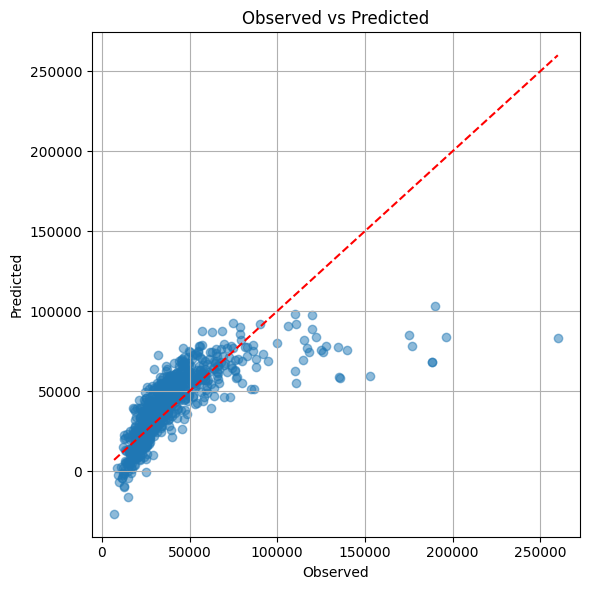

Models with the highest mean squared error:


model  Actual Price  Predicted Price  \
0               718 Cayman GT4 RS      259991.0     83369.234729   
1                     911 Turbo S      187980.0     68202.211626   
4                             911      188127.0     68526.480834   
5          Maybach GLS 600 4MATIC      196249.0     83958.784587   
7                Panamera Turbo S      176900.0     78467.609513   
...                           ...           ...              ...   
2070                S-Class S 560       65995.0     65919.952630   
2072  Tiguan 2.0T SE R-Line Black       28498.0     28445.828784   
2076                   Tacoma SR5       31474.0     31501.538614   
2083                  Civic Sport       24567.0     24555.874360   
2087                       Rio LX       13495.0     13494.668015   

         Error term  Mean Squared Error          brand    year   mileage  \
0     176621.765271        3.119525e+10        Porsche  2023.0     159.0   
1     119777.788374        1.434672e+10        Porsche  2019.0   18237.0   
4     119600.519166        1.430428e+10        Porsche  2021.0    2505.0   
5     112290.215413        1.260909e+10  Mercedes-Benz  2021.0   10290.0   
7      98432.390487        9.688935e+09        Porsche  2021.0    6379.0   
...             ...                 ...            ...     ...       ...   
2070      75.047370        5.632108e+03  Mercedes-Benz  2019.0   33672.0   
2072      52.171216        2.721836e+03     Volkswagen  2023.0    2231.0   
2076     -27.538614        7.583753e+02         Toyota  2021.0   33630.0   
2083      11.125640        1.237799e+02          Honda  2020.0   58072.0   
2087       0.331985        1.102138e-01            Kia  2018.0  112703.0   

      engine_size     price fuel_type transmission         brand_type  \
0             4.0  259991.0  Gasoline    Automatic             Luxury   
1             3.8  187980.0  Gasoline    Automatic             Luxury   
4             3.0  188127.0  Gasoline    Automatic             Luxury   
5             4.0  167500.0  Gasoline    Automatic             Luxury   
7             4.0  176900.0  Gasoline    Automatic             Luxury   
...           ...       ...       ...          ...                ...   
2070          4.0   65995.0  Gasoline    Automatic             Luxury   
2072          2.0   36495.0  Gasoline    Automatic            Premium   
2076          3.5   35987.0  Gasoline    Automatic  Standard/ Economy   
2083          1.5   24567.0  Gasoline       Manual  Standard/ Economy   
2087          1.6   10995.0  Gasoline       Manual  Standard/ Economy   

      mpg_range  
0           6.0  
1           5.0  
4           6.0  
5           9.0  
7           4.0  
...         ...  
2070        5.0  
2072        7.0  
2076        4.0  
2083        8.0  
2087        8.0  

[608 rows x 14 columns]

Understanding which variables may have attributed to higher prediction error


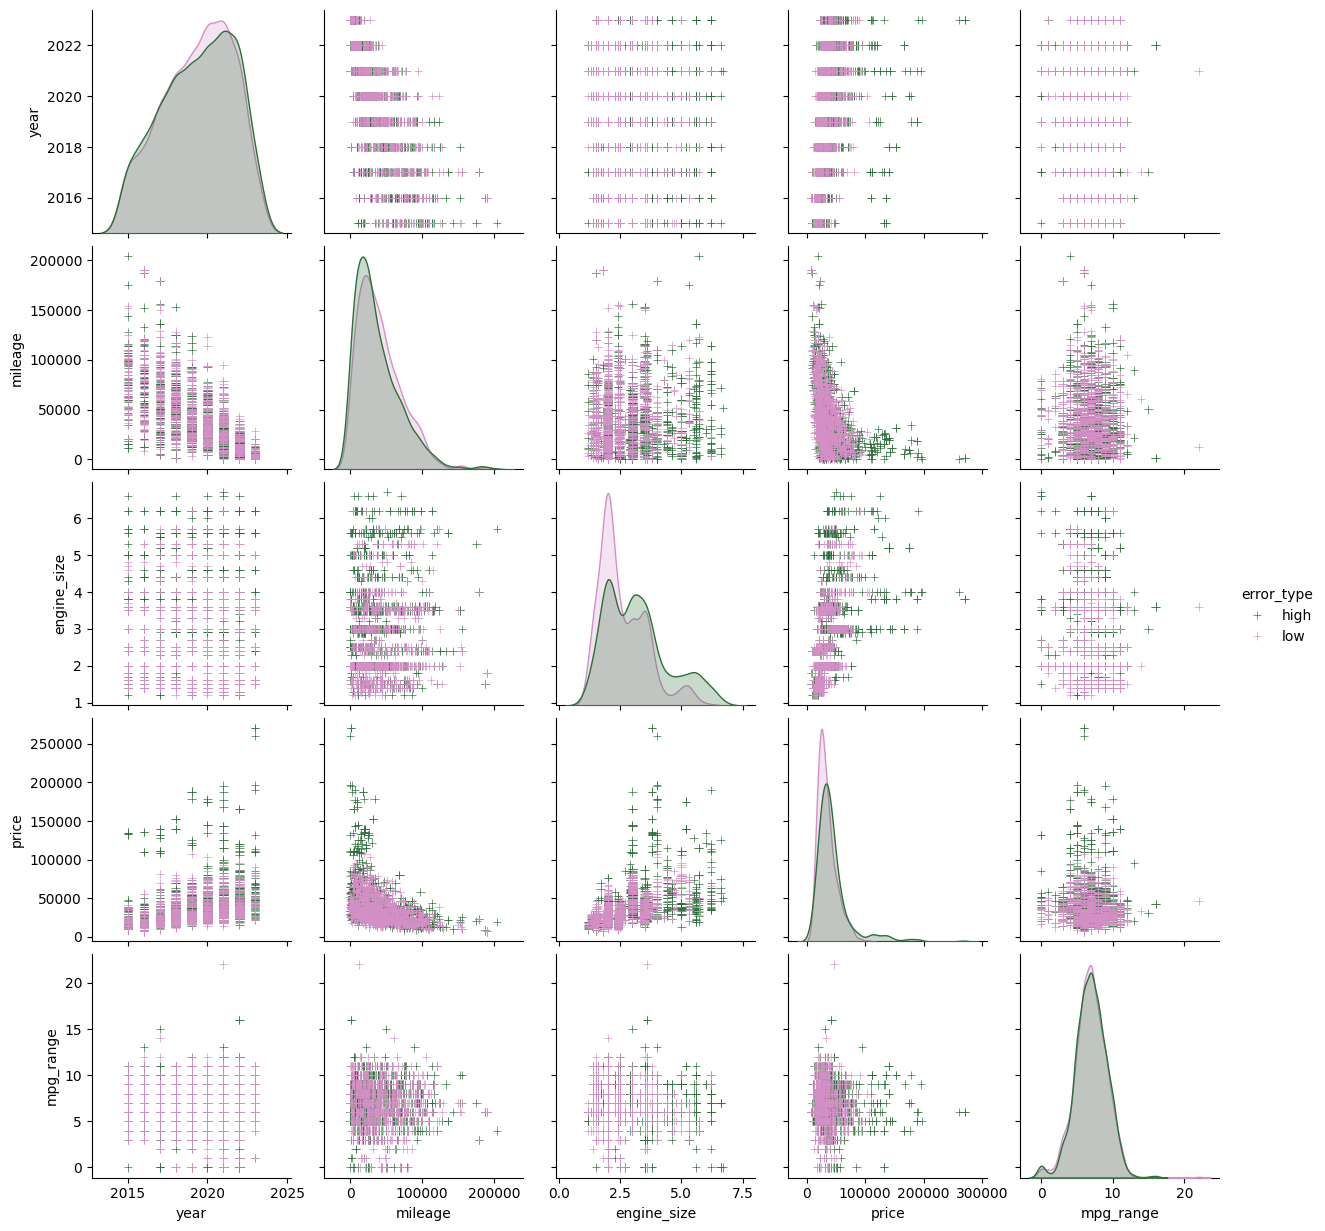

In [149]:
selected= ['year', 'mileage', 'engine_size', 'mpg_range', 'Luxury', 'Premium', 'Automatic', 'CVT', 'Dual-Clutch', 'Manual', 'Shiftable Automatic']
def test_train(x, y):
    
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, random_state=42 )
    reg = LinearRegression().fit(x_train, y_train)
    
    y_pred = reg.predict(x_test)
    y_pred = pd.Series(y_pred, index=y_test.index)

    print(f"""R^2 for training Data: {round(reg.score(x_train, y_train), 3) }
    R^2 for test Data: {round(reg.score(x_test, y_test), 3)} """)
    
    ##MSE and find models with the highest MSE 
    mse= sklearn.metrics.mean_squared_error(y_test, y_pred)
    
    print(f"""MSE: {mse}""")
    
    error=(y_test-y_pred)
    
    
    regdf=pd.DataFrame({"Actual Price": y_test, "Predicted Price": y_pred,
        "Error term": error, "Mean Squared Error": error**2})
    regdf=regdf.sort_values(by='Mean Squared Error', ascending=False)

    ## display linear model with pingouin?
    model = pg.linear_regression(x_train, y_train)
    display(model.round(2))
    
    #plot observed vs predicted 
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # ideal line
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title("Observed vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
     ## display linear model with pingouin?
    model = pg.linear_regression(x_train, y_train)
    return regdf
    
print()

##with outliers
#(og)columns 
#(for low p val)selected 
model1=test_train(cdf[columns], cdf['price']).join(df.set_index('model'), how='inner')

print("Models with the highest mean squared error:")
display(model1.reset_index().drop_duplicates('model', inplace=False))

median_mse = model1['Mean Squared Error'].median()
model1['error_type'] = model1['Mean Squared Error'].apply(lambda x: 'high' if x > median_mse else 'low')

print("Understanding which variables may have attributed to higher prediction error")
sns.pairplot(model1.drop(['Actual Price', 'Predicted Price', 'Mean Squared Error', 'Error term'], axis=1, inplace=False), hue='error_type', palette='cubehelix', markers="+" )

## Regression Model without outliers
Because of the outliers, a separate model will be used without luxury cars to understand the impact of car features to price.
- Non significant: p>0.05  - Significant: p<0.05

R^2 for training Data: 0.717
    R^2 for test Data: 0.681 
MSE: 30517414.28405866


names        coef       se          T  pval    r2  adj_r2  \
0             Intercept -3295779.82     6.21 -530924.52  0.00  0.72    0.72   
1                  year     1642.85     1.69     970.42  0.00  0.72    0.72   
2               mileage       -0.11     0.00     -30.80  0.00  0.72    0.72   
3           engine_size     4455.87   119.07      37.42  0.00  0.72    0.72   
4             mpg_range     -242.11    45.18      -5.36  0.00  0.72    0.72   
5                Luxury     7841.37   265.15      29.57  0.00  0.72    0.72   
6               Premium      -84.12   372.63      -0.23  0.82  0.72    0.72   
7                Diesel     3767.78  3256.03       1.16  0.25  0.72    0.72   
8         E85 Flex Fuel    -1796.96  3253.99      -0.55  0.58  0.72    0.72   
9              Gasoline      591.79  3091.11       0.19  0.85  0.72    0.72   
10               Hybrid     5413.45  3124.09       1.73  0.08  0.72    0.72   
11            Automatic     1187.23  1439.89       0.82  0.41  0.72    0.72   
12                  CVT    -2640.42  1461.66      -1.81  0.07  0.72    0.72   
13          Dual-Clutch   -12577.17  5540.93      -2.27  0.02  0.72    0.72   
14               Manual     1846.45  1529.55       1.21  0.23  0.72    0.72   
15  Shiftable Automatic     -231.02  1814.34      -0.13  0.90  0.72    0.72   

      CI[2.5%]   CI[97.5%]  
0  -3295792.00 -3295767.65  
1      1639.53     1646.17  
2        -0.12       -0.10  
3      4222.37     4689.37  
4      -330.71     -153.51  
5      7321.41     8361.33  
6      -814.85      646.62  
7     -2617.39    10152.95  
8     -8178.13     4584.20  
9     -5469.95     6653.53  
10     -712.97    11539.87  
11    -1636.44     4010.90  
12    -5506.78      225.94  
13   -23443.09    -1711.25  
14    -1153.03     4845.94  
15    -3789.00     3326.95

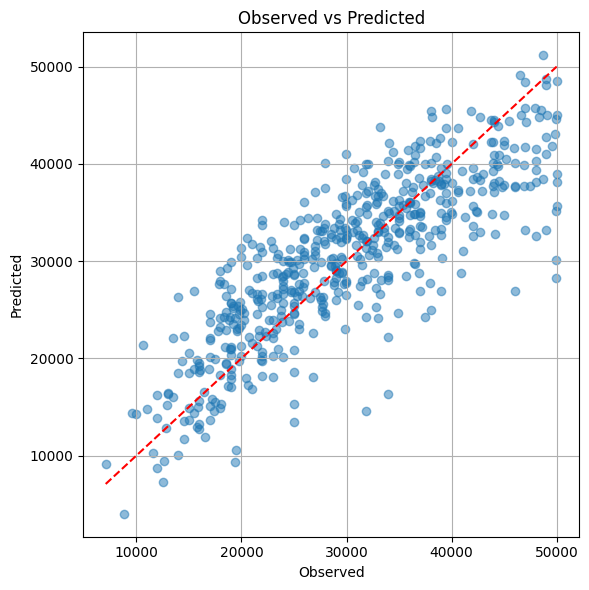


Products with the highest mean squared error:


model  Actual Price  Predicted Price  \
0       I-PACE S EV400 AWD Automatic       49948.0     28231.246058   
1                        Cayman Base       49900.0     30084.197491   
3          Romeo Giulia Quadrifoglio       45999.0     26925.080807   
5                Lancer Evolution MR       33995.0     16328.603147   
6     Lancer Evolution Final Edition       31900.0     14549.050630   
...                              ...           ...              ...   
1481    A5 45 S line quattro Premium       41990.0     42058.095658   
1494              F-PACE 35t R-Sport       28990.0     28942.063823   
1502                           440 i       35998.0     35971.763664   
1503                Q5 2.0T Prestige       22340.0     22316.902310   
1504                     Suburban LS       38711.0     38719.456759   

        Error term  Mean Squared Error       brand    year   mileage  \
0     21716.753942        4.716174e+08      Jaguar  2020.0   19041.0   
1     19815.802509        3.926660e+08     Porsche  2015.0   39710.0   
3     19073.919193        3.638144e+08        Alfa  2018.0   47710.0   
5     17666.396853        3.121016e+08  Mitsubishi  2015.0   66847.0   
6     17350.949370        3.010554e+08  Mitsubishi  2015.0   88637.0   
...            ...                 ...         ...     ...       ...   
1481    -68.095658        4.637019e+03        Audi  2021.0   19438.0   
1494     47.936177        2.297877e+03      Jaguar  2017.0   84726.0   
1502     26.236336        6.883453e+02         BMW  2018.0   40922.0   
1503     23.097690        5.335033e+02        Audi  2018.0  131766.0   
1504     -8.456759        7.151678e+01   Chevrolet  2017.0   83253.0   

      engine_size    price fuel_type transmission         brand_type  \
0             0.0  49948.0  Electric    Automatic             Luxury   
1             2.7  49900.0  Gasoline    Automatic             Luxury   
3             2.9  45999.0  Gasoline    Automatic  Standard/ Economy   
5             2.0  33995.0  Gasoline    Automatic  Standard/ Economy   
6             2.0  31900.0  Gasoline       Manual  Standard/ Economy   
...           ...      ...       ...          ...                ...   
1481          2.0  43794.0  Gasoline    Automatic             Luxury   
1494          3.0  28990.0  Gasoline    Automatic             Luxury   
1502          3.0  35998.0  Gasoline    Automatic             Luxury   
1503          2.0  22340.0  Gasoline    Automatic             Luxury   
1504          5.3  28781.0  Gasoline    Automatic  Standard/ Economy   

      mpg_range  
0           6.0  
1           7.0  
3           8.0  
5           6.0  
6           6.0  
...         ...  
1481        7.0  
1494       10.0  
1502        8.0  
1503        4.0  
1504        7.0  

[474 rows x 14 columns]

Understanding which variables may have attributed to higher prediction error


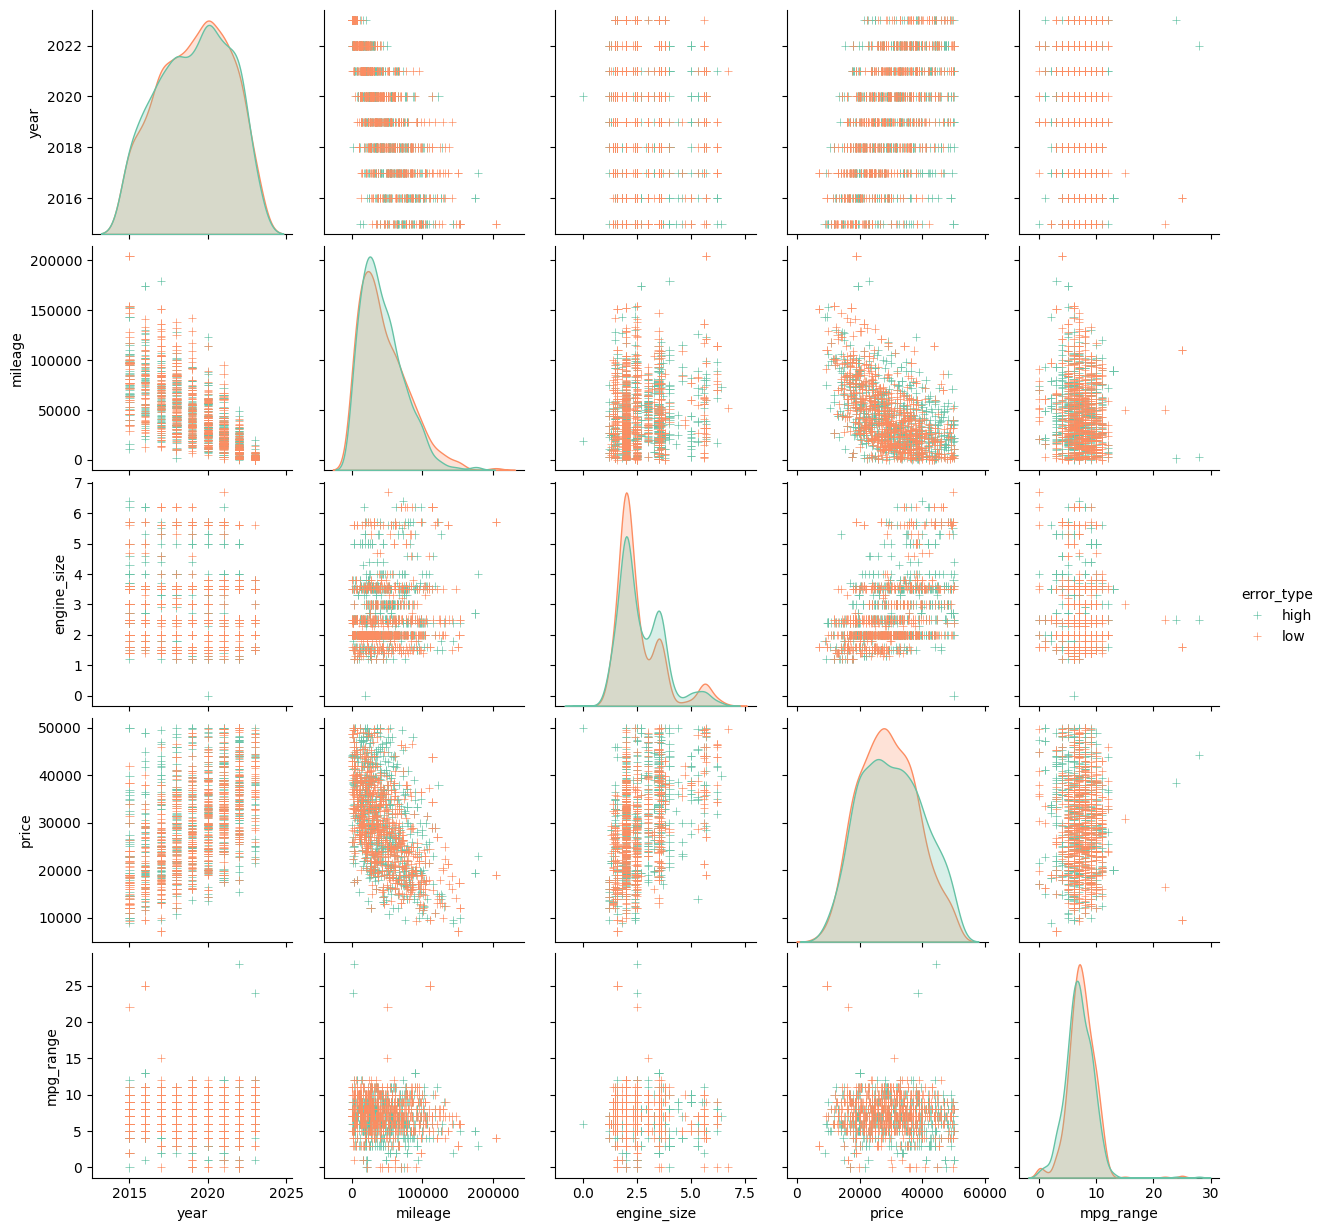

In [155]:
##without outliers
ndf=cdf[cdf['price']<50000]  
model2=test_train(ndf[columns], ndf['price']).join(df.set_index('model'), how='inner')
model2=model2[model2['price']<50000]
print()

#removing duplicate models for high level look at cars with high prediction errors instead of worrying abt 1-1 cars in various years
print("Products with the highest mean squared error:")
display(model2.reset_index().drop_duplicates('model', inplace=False))
median_mse = model2['Mean Squared Error'].median()
model2['error_type'] = model2['Mean Squared Error'].apply(lambda x: 'high' if x > median_mse else 'low')

print("Understanding which variables may have attributed to higher prediction error")
sns.pairplot(model2.drop(['Actual Price', 'Predicted Price', 'Mean Squared Error', 'Error term'], axis=1, inplace=False), hue='error_type', palette='Set2', markers="+" )
plt.show()


In [151]:
df[df['price']==795000] #thneed

brand       model    year  mileage  engine_size     price fuel_type  \
16584  Porsche  911 GT2 RS  2019.0   2185.0          3.8  795000.0  Gasoline   

      transmission brand_type  mpg_range  
16584    Automatic     Luxury        6.0

In [152]:
df[df['price']>300000] #oh my

brand                 model    year  mileage  engine_size     price  \
5284      Land  Rover Range Rover SV  2023.0    202.0          4.4  350000.0   
7509   Porsche         911 Speedster  2019.0   1446.0          4.0  364900.0   
16584  Porsche            911 GT2 RS  2019.0   2185.0          3.8  795000.0   

      fuel_type transmission brand_type  mpg_range  
5284   Gasoline    Automatic     Luxury        6.0  
7509   Gasoline       Manual     Luxury        7.0  
16584  Gasoline    Automatic     Luxury        6.0

## Evaluating Regression Models
Using mean squared error , as the observed price increase, the prediction becomes less accurate. 
The resgression model without outliers performed 10X better than the model with outliers (containing prices > $50,000).